In [1]:
import numpy as np
import pandas as pd
import geopandas as gp
import os
import subprocess
import statsmodels.formula.api as smf

import pylab as pl
%pylab inline

# make sure we are at the top of the repo
wd = subprocess.check_output('git rev-parse --show-toplevel', shell = True)
os.chdir(wd[:-1]) #-1 removes \n

Populating the interactive namespace from numpy and matplotlib


### Set up the data

In [2]:
# read in cleaned data
df = gp.read_file('data/citi_docks/citi_docks.shp')
df = df.dropna()
df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,morning,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,workers
0,37.500000,751.75,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,0,1253,510.5,39.500000,1561.0,232.000000,302.0,24.555556
1,37.500000,751.75,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,1,3970,510.5,39.500000,1561.0,232.000000,302.0,24.555556
2,0.000000,636.50,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,0,8988,342.5,112.500000,1043.0,163.958333,488.0,256.000000
3,0.000000,636.50,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,1,5659,342.5,112.500000,1043.0,163.958333,488.0,256.000000
4,7.666667,407.00,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,0,2822,112.0,166.333333,857.0,206.666667,502.0,31.166667


In [3]:
# combine no vehicle units into one column

df['no_vehicle'] = df['no_vehic_1'] + df['no_vehicle']

# calculate nonlinearities
df['dist_tohom2'] = df['dist_tohom']**2
df['log_workers'] = np.log10(df['workers'])
df['log_residents'] = np.log10(df['residents'])
df['log_rides'] = np.log10(df['n_rides'])

# interaction terms
df['dist_work_morn'] = df['dist_towor'] * df['morning']
df['dist_home_aft'] = df['dist_tohom'] * (1 - df['morning'])

df.head()

,bike,commute_ti,dist_tohom,dist_towor,geometry,income_pc,morning,n_rides,no_vehic_1,no_vehicle,pop,residents,station_id,workers,dist_tohom2,log_workers,log_residents,log_rides,dist_work_morn,dist_home_aft
0,37.500000,751.75,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,0,1253,510.5,550.000000,1561.0,232.000000,302.0,24.555556,8.410180,1.39015,2.365488,3.097951,0.000000,2.900031
1,37.500000,751.75,2.900031,2.009997,POINT (990367.1991470763 201894.5034764804),35375.000000,1,3970,510.5,550.000000,1561.0,232.000000,302.0,24.555556,8.410180,1.39015,2.365488,3.598791,2.009997,0.000000
2,0.000000,636.50,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,0,8988,342.5,455.000000,1043.0,163.958333,488.0,256.000000,11.161296,2.40824,2.214733,3.953663,0.000000,3.340853
3,0.000000,636.50,3.340853,1.241825,POINT (985989.2338921009 214874.8949317572),63984.000000,1,5659,342.5,455.000000,1043.0,163.958333,488.0,256.000000,11.161296,2.40824,2.214733,3.752740,1.241825,0.000000
4,7.666667,407.00,3.133704,2.381631,POINT (989421.2936561276 199484.8415778317),32061.666667,0,2822,112.0,278.333333,857.0,206.666667,502.0,31.166667,9.820103,1.49369,2.315270,3.450557,0.000000,3.133704


### Develop a simple model first

In [21]:
# regress number of rides on average commute distance
lm = smf.ols('log_rides ~ dist_towor + dist_tohom + morning', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_rides   R-squared:                       0.169
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     32.81
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           2.55e-19
Time:                        16:00:00   Log-Likelihood:                -52.119
No. Observations:                 488   AIC:                             112.2
Df Residuals:                     484   BIC:                             129.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      3.8108      0.053     71.281      0.000         3.706     3.916
dist_towor    -0.2766      0.032     -8.520      0.000        -0.340    -0.213
dist_tohom     0.1117      0.020      5.675      0.000         0.073     0.150
morning       -0.1224      0.024     -4.999      0.000        -0.170    -0.074
==============================================================================
Omnibus:                      138.993   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              522.731
Skew:                          -1.253   Prob(JB):                    3.09e-114
Kurtosis:                       7.407   Cond. No.                         16.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Investigation

It seems weird that there is a significant positive coefficient on distance to home. What's going on?

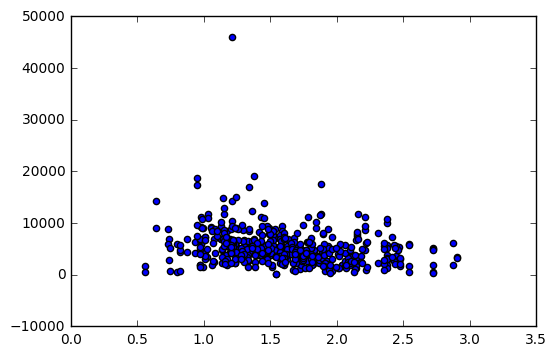

In [26]:
pl.scatter(df['dist_towor'], df['n_rides'])

There appears to be some non linearity! Can we improve the model with polynomials?

In [13]:
lm = smf.ols('log_rides ~ dist_towor + dist_tohom2 + dist_tohom + morning', data = df).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_rides   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.175
Method:                 Least Squares   F-statistic:                     26.81
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           4.21e-20
Time:                        15:58:17   Log-Likelihood:                -48.373
No. Observations:                 488   AIC:                             106.7
Df Residuals:                     483   BIC:                             127.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       3.3978      0.160     21.216      0.000         3.083     3.712
dist_towor     -0.2349      0.036     -6.585      0.000        -0.305    -0.165
dist_tohom2    -0.0397      0.015     -2.733      0.006        -0.068    -0.011
dist_tohom      0.3540      0.091      3.900      0.000         0.176     0.532
morning        -0.1224      0.024     -5.033      0.000        -0.170    -0.075
==============================================================================
Omnibus:                      135.637   Durbin-Watson:                   1.623
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              512.013
Skew:                          -1.220   Prob(JB):                    6.57e-112
Kurtosis:                       7.385   Cond. No.                         166.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Look at a more extensive model

In [14]:
lm = smf.ols('log_rides ~ morning + dist_tohom + dist_tohom2 + dist_towor + \
pop + log_workers + log_residents + bike + income_pc + commute_ti + no_vehicle', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_rides   R-squared:                       0.208
Model:                            OLS   Adj. R-squared:                  0.189
Method:                 Least Squares   F-statistic:                     11.33
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           8.25e-19
Time:                        15:58:24   Log-Likelihood:                -40.542
No. Observations:                 488   AIC:                             105.1
Df Residuals:                     476   BIC:                             155.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------
Intercept         2.9586      0.232     12.751      0.000         2.503     3.415
morning          -0.1224      0.024     -5.077      0.000        -0.170    -0.075
dist_tohom        0.4202      0.099      4.253      0.000         0.226     0.614
dist_tohom2      -0.0567      0.016     -3.440      0.001        -0.089    -0.024
dist_towor       -0.1552      0.047     -3.283      0.001        -0.248    -0.062
pop              -0.0001   4.72e-05     -2.659      0.008        -0.000 -3.28e-05
log_workers       0.0293      0.030      0.978      0.328        -0.030     0.088
log_residents     0.1228      0.059      2.083      0.038         0.007     0.239
bike             -0.0007      0.001     -0.804      0.422        -0.002     0.001
income_pc     -4.279e-07   3.93e-07     -1.088      0.277      -1.2e-06  3.45e-07
commute_ti        0.0003      0.000      2.473      0.014      5.48e-05     0.000
no_vehicle       -0.0001      0.000     -0.863      0.389        -0.000     0.000
==============================================================================
Omnibus:                      137.503   Durbin-Watson:                   1.676
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              543.659
Skew:                          -1.221   Prob(JB):                    8.83e-119
Kurtosis:                       7.558   Cond. No.                     1.89e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.89e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

This overall model is not much improved but there is reason to believe some of these variables may be useful

### Feature Selection

### Another model following simple feature selection

In [15]:
lm = smf.ols('log_rides ~ morning + dist_tohom2 + dist_tohom + dist_towor + workers + commute_ti', data = df).fit()

lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_rides   R-squared:                       0.187
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     18.45
Date:                Wed, 07 Dec 2016   Prob (F-statistic):           2.46e-19
Time:                        15:58:38   Log-Likelihood:                -46.749
No. Observations:                 488   AIC:                             107.5
Df Residuals:                     481   BIC:                             136.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept       3.2730      0.177     18.462      0.000         2.925     3.621
morning        -0.1224      0.024     -5.039      0.000        -0.170    -0.075
dist_tohom2    -0.0501      0.016     -3.206      0.001        -0.081    -0.019
dist_tohom      0.3985      0.094      4.239      0.000         0.214     0.583
dist_towor     -0.2101      0.043     -4.943      0.000        -0.294    -0.127
workers      4.633e-05   4.39e-05      1.056      0.292     -3.99e-05     0.000
commute_ti   4.081e-05   2.52e-05      1.621      0.106     -8.67e-06  9.03e-05
==============================================================================
Omnibus:                      137.500   Durbin-Watson:                   1.631
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              523.280
Skew:                          -1.234   Prob(JB):                    2.35e-114
Kurtosis:                       7.432   Cond. No.                     1.80e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.8e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [9]:
df['pred'] = lm.predict()
df['resid'] = df['n_rides'] - df['pred']

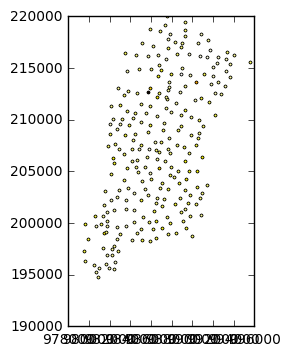

In [10]:

df.plot(column = 'resid', cmap = 'hot_r')